In [34]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skew, kurtosis

In [29]:
diabetes_df = pd.read_csv('diabetes.csv')
train_mask = diabetes_df.columns[:-1]
target_mask = ['Outcome']

#### DISCARD!

ALL ACCURACY MEASUREMENTS WERE PERFORMED ON TRAINSET INTENTIONALLY !

#### SELF IMPLEMENTED GRAD

In [384]:
def h(theta, x):
    return 1. / (1 + np.exp(-(theta * x).sum(axis=1)))

In [385]:
X = np.array(diabetes_df[train_mask])
Y = np.array(diabetes_df[target_mask])

In [386]:
%%time
alpha = 1e-4
theta = np.zeros(X.shape[1], dtype=float)

N_iter = 200_000

for n in range(N_iter):
    k = y - h(theta, X)
    if not n % 50_000:
        print (n,theta)
        print(f'loss = {(k**2).sum()}')
    theta += alpha/X.shape[0] * np.fromiter(
        (np.dot(k, X[:,i]) for i in range(X.shape[1])), dtype=float)
print(f'\ntheta = {theta}, loss = {(k**2).sum()}')

0 [0. 0. 0. 0. 0. 0. 0. 0.]
loss = 192.0
50000 [ 0.12611695  0.0132976  -0.03024027  0.00097467  0.00078454 -0.00331032
  0.03345013 -0.01484684]
loss = 160.0992981981655
100000 [ 0.12638318  0.01325747 -0.03024552  0.0008927   0.00077918 -0.0034707
  0.06414614 -0.01493477]
loss = 160.02748408259515
150000 [ 0.12658267  0.01322148 -0.03025062  0.00081902  0.00077446 -0.00361467
  0.09156512 -0.01500686]
loss = 159.96961069280053

theta = [ 0.12676463  0.01318964 -0.03025586  0.00075298  0.00077032 -0.0037432
  0.11605335 -0.0150718 ], loss = 159.92259500105985
CPU times: user 6.47 s, sys: 3.84 ms, total: 6.48 s
Wall time: 6.48 s


In [387]:
from sklearn.metrics import accuracy_score

In [388]:
print(
    accuracy_score(np.asarray(h(theta, X).round(), dtype=int), Y)
)
# print(
#     accuracy_score(np.asarray(h(log_regr.coef_, X).round(), dtype=int), Y)
# )

0.6940104166666666


#### SKLEARN LOGISTIC REGRESSOR

In [389]:
from sklearn.linear_model import LogisticRegression

In [390]:
X_data = np.array(diabetes_df[train_mask])
Y_data = np.array(diabetes_df[target_mask]).reshape(-1)

In [391]:
log_regr = LogisticRegression(max_iter=10_000, fit_intercept=False)
log_regr.fit(X_data, Y_data)
log_regr.score(X_data, Y_data)

0.69921875

In [392]:
extended_train_mask = log_train_mask + ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
X_data_1 = np.array(diabetes_df[extended_train_mask])

In [393]:
log_regr1 = LogisticRegression(max_iter=10_000, fit_intercept=False)
log_regr1.fit(X_data_1, Y_data)
log_regr1.score(X_data_1, Y_data)

0.7526041666666666

#### COMPARE RESULTS

In [394]:
# ONE CAN SEE THE ACCURACY DIFFERENCE
print(
    accuracy_score(np.asarray(h(theta, X).round(), dtype=int), Y)
)
print(
    accuracy_score(np.asarray(h(log_regr.coef_, X).round(), dtype=int), Y)
)
print(
    accuracy_score(np.asarray(h(log_regr1.coef_, X_data_1).round(), dtype=int), Y)
)

0.6940104166666666
0.69921875
0.7526041666666666


BASELINE GRADIENT DESCENT SHOWS THE LITTLE UNDERPERFORM COMPARE WITH BUILT-IN SKLEARN LOGISTIC REGRESSOR

WHILEST THE LOGISTIC REGRESSOR ON SCALED NORMALIZED FEATURES OUTPERFORMS THE BOTH PREVIOUS APPROACHES

#### DATA ANALYSIS

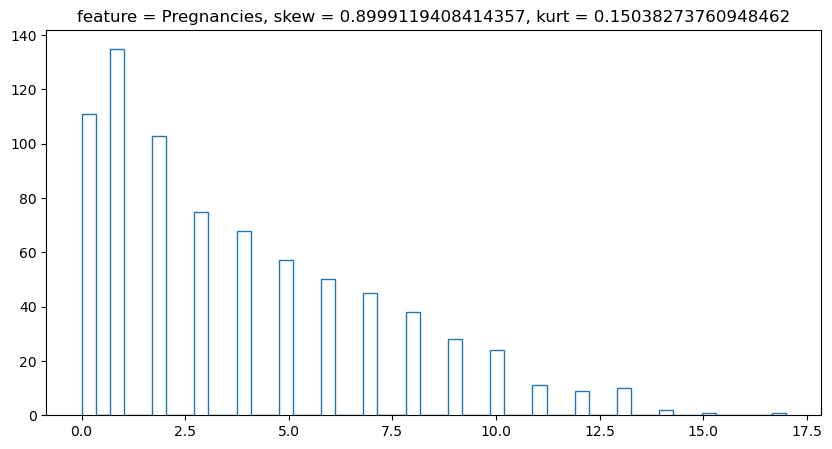

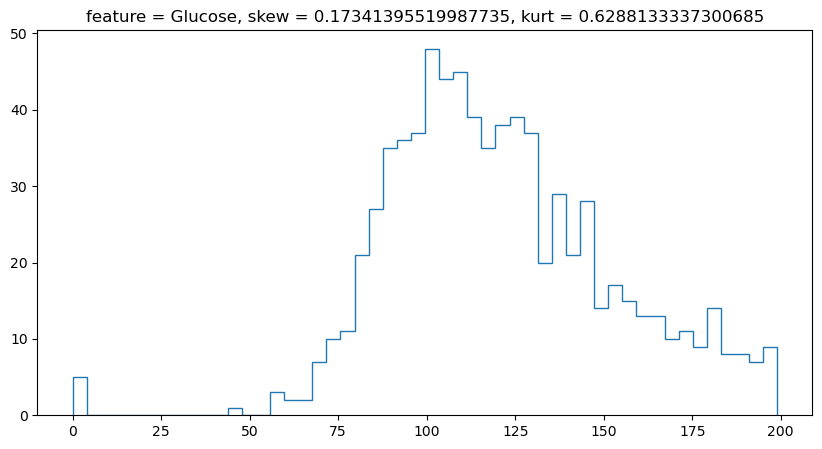

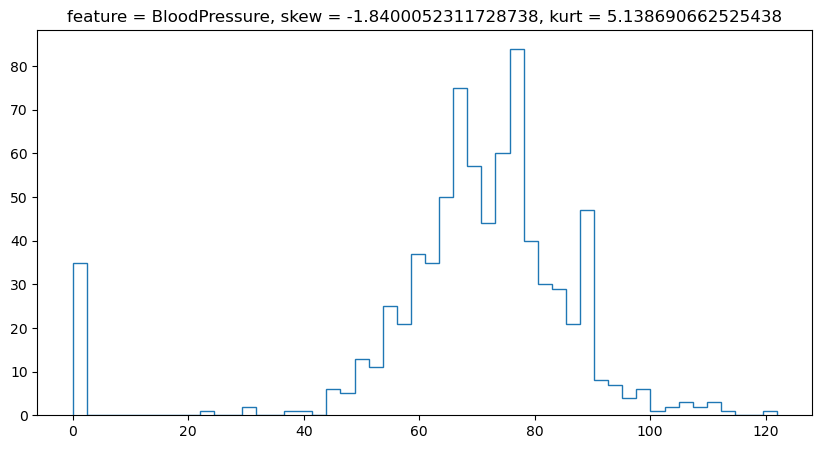

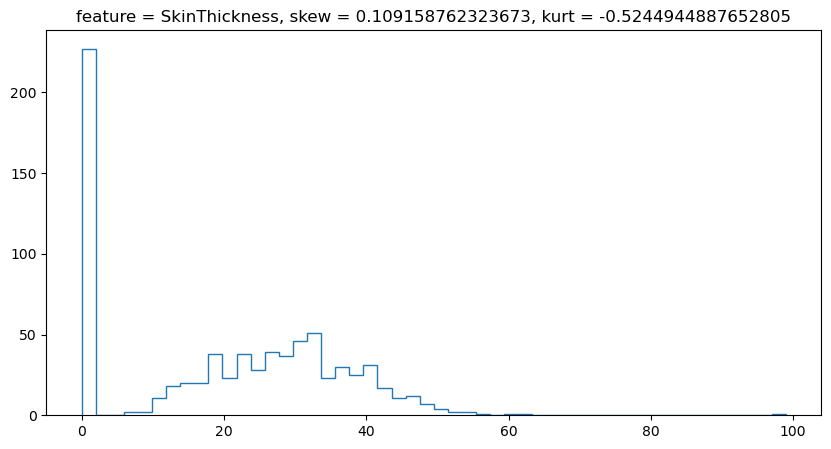

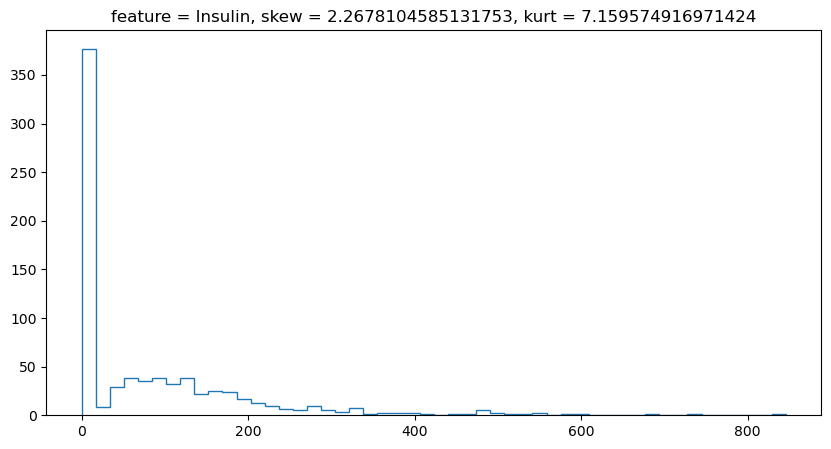

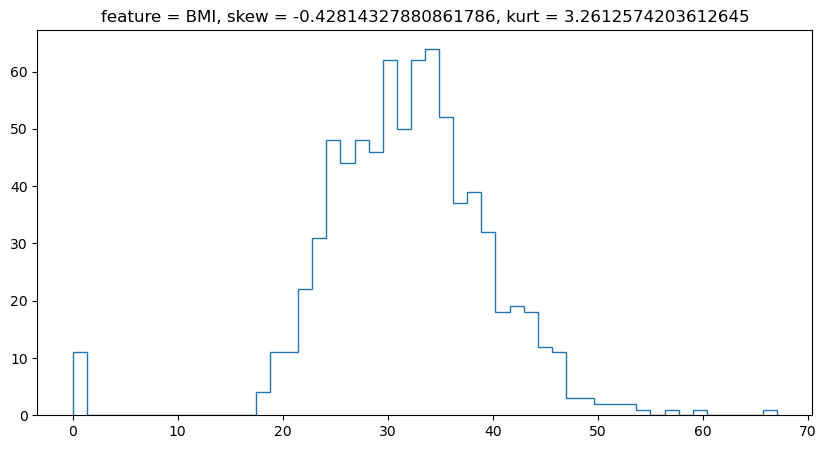

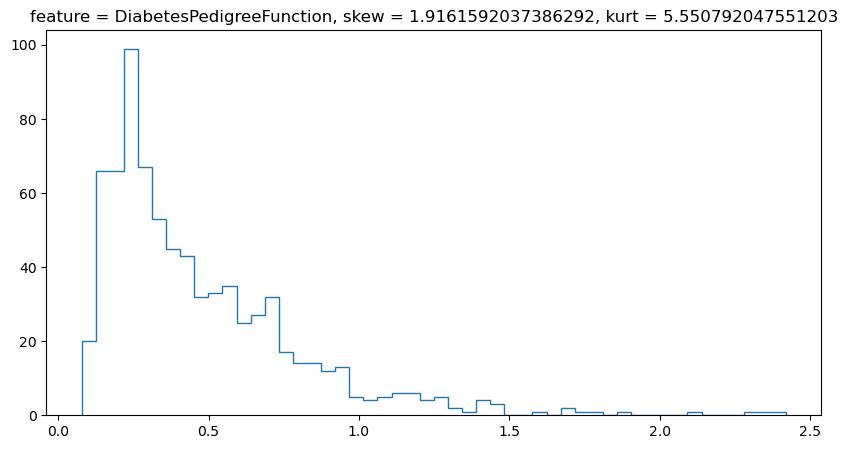

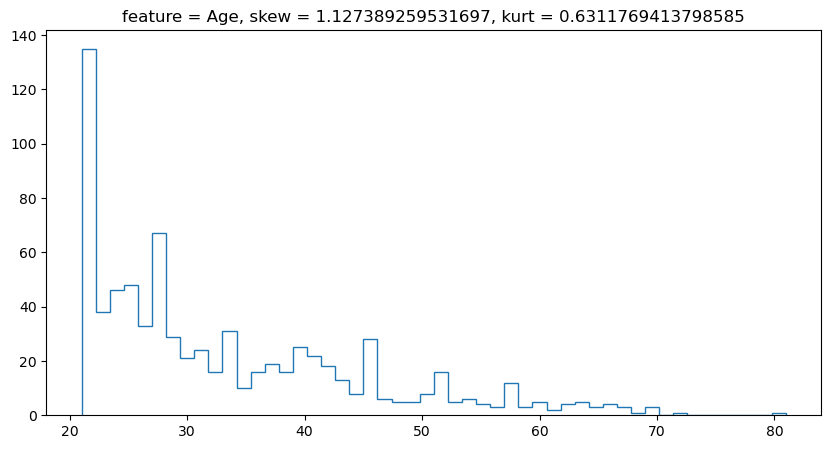

In [38]:
for tr in train_mask:
    plt.figure(figsize=(10, 5))
    data = diabetes_df[tr]
    plt.hist(
        data,
        bins=50,
        histtype='step'
    )
    plt.title(f"feature = {tr}, skew = {skew(data)}, kurt = {kurtosis(data)}")
    
# change numeraire of lognormal distr" Pregancies, Insulin, DiabetesPedigreeFunction, Age -> Maybe standartize

In [181]:
diabetes_df['Log_Pregnancies'] = diabetes_df['Pregnancies'].apply(lambda x : np.log(x + 1))
diabetes_df['Log_Insulin'] = diabetes_df['Insulin'].apply(lambda x : np.log(x + 1))
diabetes_df['Log_DiabetesPedigreeFunction'] = diabetes_df['DiabetesPedigreeFunction'].apply(lambda x : np.log(x + 1))
diabetes_df['Log_Age'] = diabetes_df['Age'].apply(lambda x : np.log(x + 1))

In [53]:
diabetes_df['Log_Pregnancies'] = (diabetes_df['Log_Pregnancies'].sub(diabetes_df['Log_Pregnancies'].mean())).div(diabetes_df['Log_Pregnancies'].std())
diabetes_df['Log_Insulin'] = (diabetes_df['Log_Insulin'].sub(diabetes_df['Log_Insulin'].mean())).div(diabetes_df['Log_Insulin'].std())
diabetes_df['Log_DiabetesPedigreeFunction'] = (diabetes_df['Log_DiabetesPedigreeFunction'].sub(diabetes_df['Log_DiabetesPedigreeFunction'].mean())).div(diabetes_df['Log_DiabetesPedigreeFunction'].std())
diabetes_df['Log_Age'] = (diabetes_df['Log_Age'].sub(diabetes_df['Log_Age'].mean())).div(diabetes_df['Log_Age'].std())

In [182]:
log_train_mask = ['Log_Pregnancies', 'Log_Insulin', 'Log_DiabetesPedigreeFunction', 'Log_Age']

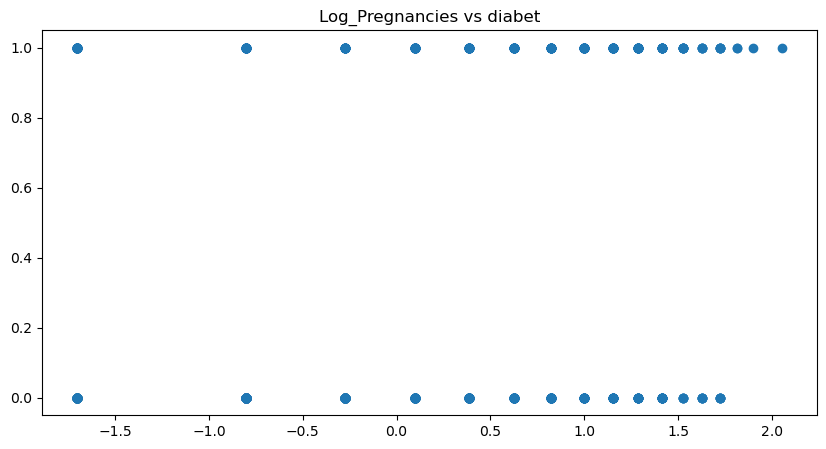

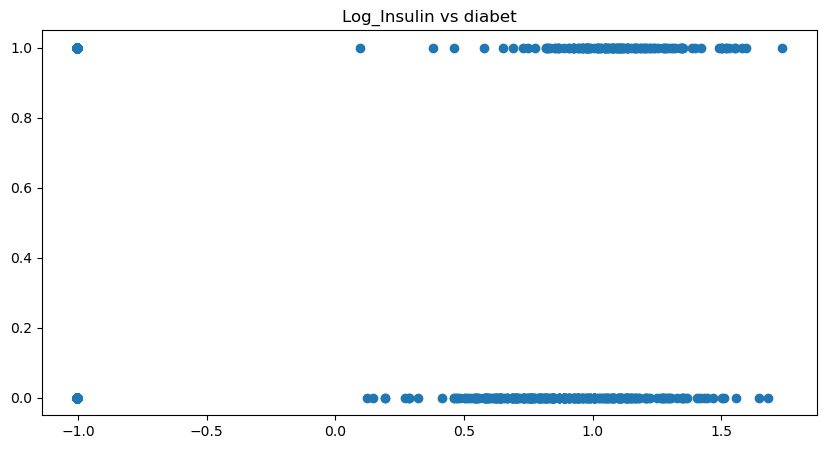

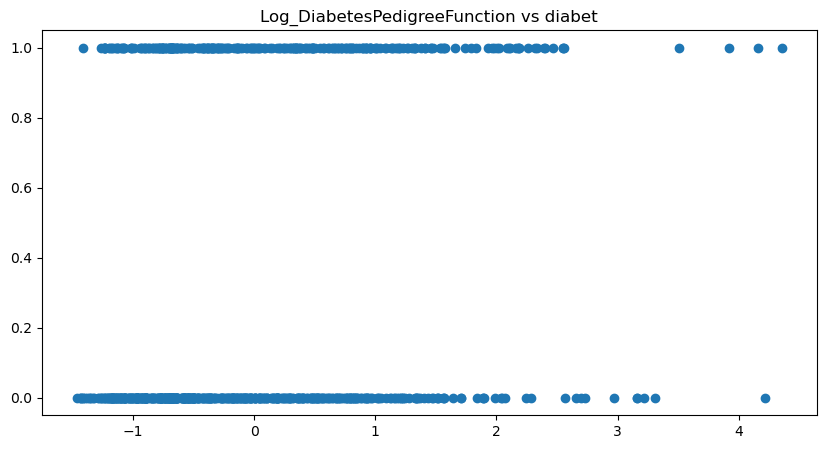

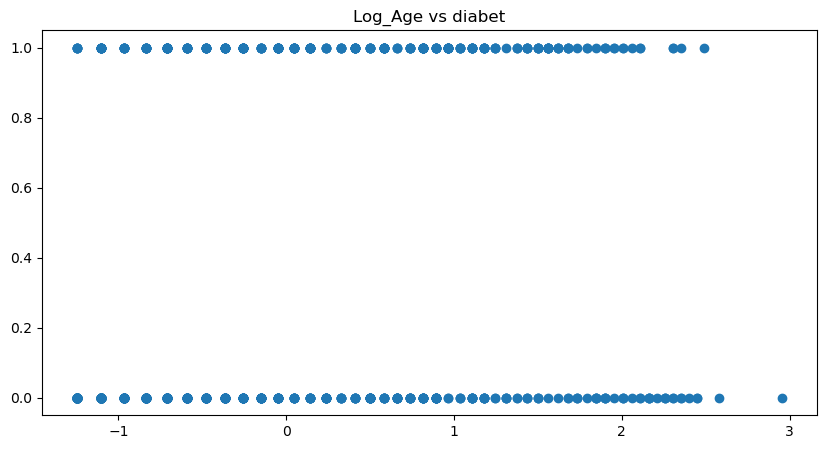

In [55]:
for tr in log_train_mask:
    plt.figure(figsize=(10, 5))
    data = diabetes_df[tr]
    plt.scatter(data, diabetes_df[target_mask])
    plt.title(f"{tr} vs diabet")
    
# change numeraire of lognormal distr" Pregancies, Insulin, DiabetesPedigreeFunction, Age -> Maybe standartize

#### JNP GRAD IMPLEMENTATION

In [445]:
def get_loss(theta, x, y):
    y_pred = 1. / (1 + jnp.exp((theta * X).sum(axis=1)))
    return jnp.square(y - y_pred).mean()

theta_grad = grad(get_loss, 0)

def alpha_loss(lr, grad, w, x, y):
    #print(f'\n\nparam = {w - lr * grad}\n\n')
    return get_loss(w - lr * grad, x, y)

alpha_grad = grad(alpha_loss, 0)

In [435]:
from scipy.optimize import minimize_scalar

In [ ]:
%%time
Y = jnp.array(diabetes_df.Outcome)
X = jnp.array(diabetes_df[train_mask])

alpha = 1e-3
theta = jnp.zeros(X.shape[1], dtype=float)
N = 10_000
K = 20

dh_dtheta = 0
min_fun = lambda a: alpha_loss(a, dh_dtheta, theta, X, Y)


for n in range(N):
    loss = get_loss(theta, X, y)
    dh_dtheta = theta_grad(theta, X, y)
        
    if n % 1000 == 0:
        print(f'theta = {theta}, \nloss = {jnp.square(y - 1. / (1 + jnp.exp((theta * X).sum(axis=1)))).sum()}, alpha = {alpha},\ngrad = {dh_dtheta}\n')
    
    alpha = 1e-4
    for i in range(K):
        a_grad = alpha_grad(alpha, dh_dtheta, theta, X, y)
        #print(f'alpha = {alpha}, alpha_grad = {a_grad}')
        alpha -= a_grad * 1e-5 * jnp.exp(-i/K * 1e-1)
        
    theta -= alpha * dh_dtheta * jnp.exp(n/N * 1e-3)
    
print(f'theta = {theta}, \nloss = {jnp.square(y - 1. / (1 + jnp.exp((theta * X).sum(axis=1)))).sum()}')

In [465]:
%%time
Y = jnp.array(diabetes_df.Outcome)
X = jnp.array(diabetes_df[extended_train_mask])

alpha = 1e-3
theta = jnp.zeros(X.shape[1], dtype=float)
N = 10_000
K = 20

dh_dtheta = 0
min_fun = lambda a: alpha_loss(a, dh_dtheta, theta, X, Y)


for n in range(N):
    loss = get_loss(theta, X, y)
    dh_dtheta = theta_grad(theta, X, y)
        
    if n % 1000 == 0:
        print(f'theta = {theta}, \nloss = {jnp.square(y - 1. / (1 + jnp.exp((theta * X).sum(axis=1)))).sum()}, alpha = {alpha},\ngrad = {dh_dtheta}\n')
    
    # alpha = 1e-4
    # for i in range(K):
    #     a_grad = alpha_grad(alpha, dh_dtheta, theta, X, y)
    #     #print(f'alpha = {alpha}, alpha_grad = {a_grad}')
    #     alpha -= a_grad * 1e-5 * jnp.exp(-i/K * 1e-1)
        
    theta -= alpha * dh_dtheta * jnp.exp(n/N * 1e-3)
    
print(f'theta = {theta}, \nloss = {jnp.square(y - 1. / (1 + jnp.exp((theta * X).sum(axis=1)))).sum()}')

theta = [0. 0. 0. 0. 0. 0. 0. 0.], 
loss = 192.0, alpha = 0.001,
grad = [-0.06602417 -0.18095309 -0.01908139 -0.24246365 -5.5771484  -4.918946
 -1.2669272  -1.866504  ]

theta = [-0.00908272  0.03514774 -0.00081475  0.03593263 -0.0198565   0.03396226
 -0.00375021  0.00491716], 
loss = 166.0199432373047, alpha = 0.001,
grad = [-0.02381308 -0.10133477 -0.00855944 -0.12536578 -3.4104006  -1.8616115
 -0.5740149  -0.8357641 ]

theta = [-0.01823041  0.05933185 -0.00186153  0.07032183 -0.02038106  0.03316519
 -0.00591059  0.00425905], 
loss = 165.01455688476562, alpha = 0.001,
grad = [-0.02679218 -0.09617952 -0.00914098 -0.13208117 -3.6832716  -2.0097888
 -0.6197339  -0.9037233 ]

theta = [-0.02711094  0.07563579 -0.0030407   0.10428958 -0.02074621  0.03225714
 -0.00738502  0.00368127], 
loss = 164.15203857421875, alpha = 0.001,
grad = [-0.02880337 -0.0924001  -0.00951226 -0.13642007 -3.8614454  -2.106033
 -0.64907354 -0.94822305]

theta = [-0.03577879  0.08656622 -0.00431141  0.13791817 -0.0

In [466]:
print(
    accuracy_score(np.asarray(h(theta, X).round(), dtype=int), Y)
)

0.3046875


CAN NOT IMPLEMENT THE RESULT - WE HAVE GOT THE SAME LOSS BUT THE DIFFERENT WEIGHTS VECTOR SO THE ACCURACY IS POOR !